# Automated Voigt Species Plots (VSP)

### This code is able to take the component groups and turn it into a csv file that contains all the information about the Veeper fits. It then reduces the pandas data frame to just the fits of the galaxy and runs them through a function that returns the voigt fit and the velocities associated with them to make voigt species plots similar to those seen in Figure 3 of Werk et al. 2013 (https://iopscience.iop.org/article/10.1088/0067-0049/204/2/17/pdf)

Note: This code is meant to be run after the veeper_create-run-collate.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#plotting things 
%config InlineBackend.figure_format = 'retina'

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 14

# update various fontsizes to match
params = {'figure.figsize': (18, 12),
          'legend.fontsize': 11,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

import glob
import astropy.units as u
from linetools.spectralline import AbsLine
from linetools.spectra import io as lsio
from linetools.isgm.abscomponent import AbsComponent
from linetools.spectra.xspectrum1d import XSpectrum1D
from linetools.lists.linelist import LineList

#### Information for each Galaxy/QSO LOS: 
- ##### NGC 3489 / J1101: 
    - json_path =  '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101+1429/SamIDs_Nov28_2022.json' 
    - norm = 'J1101+1429_nbin3_jwnorm.fits'
    - Galaxy z: 0.002258
    - QSO z: 0.635
    - V (Helio) [km/s]: 676.9

- ##### NGC 4026 / J1159: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159+5106/SamIDs_meth3_Nov28_2022.json'
    - norm = 'J1159+5106_nbin3_jwnorm_meth3.fits'
    - Galaxy z: 0.003286
    - QSO z: 0.524
    - V (Helio) [km/s]: 985.1
    
- ##### NGC 4736 / J1249: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249+4122/SamIDs_Nov28_2022.json'
    - norm = 'J1249+4122_nbin3_visit12_jwnorm.fits'
    - Galaxy z: 0.001027
    - QSO z: 0.368
    - V (Helio) [km/s]: 307.8
    
- ##### NGC 3414 / 1051: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/SamIDs_Nov29_2022.json'
    - norm = 'J1051+2805_nbin3_jwnorm.fits'
    - Galaxy z: 0.0049
    - QSO z: 0.423
    - V (Helio) [km/s]: 1469.8
    - all_vp_df.loc[(all_vp_df['zsys'] > 0.002) &  (all_vp_df['zsys'] < 0.005) ]
    - specfile = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits'
    
- ##### NGC 3627 / J1123: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1123+1257/SamIDs_Nov29_2022.json'
    - norm = 'J1123+1257_nbin3_BASIC_jwnorm.fits'
    - Galaxy z: 0.00243
    - QSO z: 0.315
    - V (Helio) [km/s]: 721

- ##### NGC 1097 / J0246: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J0246-3007/SamIDs_Nov28_2022.json'
    - norm = 'J0246-3007_nbin3_allvisits_jwnorm.fits'
    - Galaxy z: 0.00424
    - QSO z: 0.524
    - V (Helio) [km/s]: 1271.1

- ##### NGC 4564 / J1235: 
    - json_path = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1235+1123/SamIDs_Nov28_2022.json'
    - norm = 'J1235+1123_twovisits_m3_jwnorm.fits'
    - Galaxy z: 0.003809
    - QSO z: 0.949
    - V (Helio) [km/s]: 1141.9

In [70]:
all_vp_df_J1101 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1101/all_vp.csv')
all_vp_df_J1159 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1159/all_vp.csv')
all_vp_df_J1249 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1249/all_vp.csv')
all_vp_df_J1051 = pd.read_csv('/Users/samgarza/Documents/COS-Holes/veeper_and_voigt/J1051/all_vp.csv')

In [46]:
#We care about the absorption features that we see around the galaxy so need to input the correct info for each one 
#Used some galaxy criterion to only see the lines that fit what I want to plot 

gal_df_J1101 = all_vp_df_J1101.loc[(all_vp_df_J1101['zsys'] > 0.0) & (all_vp_df_J1101['zsys'] < 0.003) ]
gal_df_J1101 

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
1,1,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1560.3092,0.00115,13.858,0.067,70.700,13.578,-7.827,9.543,...,-119.1439,119.1439,1561.489416,1562.729616,4838,4871,0.00113,C I,c,--
2,2,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1656.9284,0.00115,13.858,0.000,70.700,0.000,-7.827,0.000,...,-119.1439,119.1439,1658.181699,1659.498696,7473,7509,0.00113,C I,c,--
3,3,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1560.3092,0.00252,13.812,0.067,41.600,8.465,6.425,5.890,...,-105.2015,105.2015,1563.692380,1564.787450,4898,4927,0.00254,C I,b,--
4,4,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1656.9284,0.00252,13.812,0.000,41.600,0.000,6.425,0.000,...,-105.2015,105.2015,1660.521077,1661.683958,7537,7568,0.00254,C I,b,--
5,5,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1425.0300,0.00223,13.724,0.131,48.911,15.453,-1.196,11.274,...,-60.8394,60.8394,1427.914078,1428.492464,1197,1213,0.00222,S I,b,--
6,6,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1425.0300,0.00279,14.519,0.026,85.000,6.629,-14.166,4.497,...,-116.6089,116.6089,1428.446060,1429.554635,1211,1242,0.00274,S I,b,--
9,9,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1670.7886,0.00039,12.704,0.093,41.500,11.812,-22.454,7.951,...,-54.5020,54.5020,1671.133185,1671.740681,7826,7842,0.00031,AlII,b,--
11,11,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1526.7070,0.00040,13.784,0.058,20.000,4.533,-2.758,2.892,...,-34.2222,34.2222,1527.138061,1527.486617,3901,3911,0.00039,SiII,b,--
14,14,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1393.7602,0.00033,12.877,0.373,39.200,27.775,-34.305,26.794,...,-72.2468,72.2468,1393.882657,1394.554419,269,288,0.00021,SiIV,c,--
15,15,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101...,1402.7729,0.00033,12.877,0.000,39.200,0.000,-34.305,0.000,...,-72.2468,72.2468,1402.896148,1403.572255,515,533,0.00021,SiIV,c,--


In [56]:
gal_df_J1159 = all_vp_df_J1159.loc[(all_vp_df_J1159['zsys'] > 0.002) & (all_vp_df_J1159['zsys'] < 0.005) ]
gal_df_J1159

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
4,4,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1548.2040,0.00303,13.441,0.084,16.100,5.776,-7.257,3.514,...,-40.5596,40.5596,1552.678972,1553.097892,4625,4636,0.00300,C IV,c,--
5,5,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1550.7810,0.00303,13.441,0.000,16.100,0.000,-7.257,0.000,...,-40.5596,40.5596,1555.263420,1555.683038,4695,4707,0.00300,C IV,c,--
6,6,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1548.2040,0.00335,14.052,0.137,46.744,10.614,-5.136,9.976,...,-48.1646,48.1646,1553.138808,1553.636276,4637,4651,0.00333,C IV,c,--
7,7,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1550.7810,0.00335,14.052,0.000,46.744,0.000,-5.136,0.000,...,-48.1646,48.1646,1555.724022,1556.222318,4708,4721,0.00333,C IV,c,--
8,8,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1548.2040,0.00373,13.990,0.184,61.600,27.651,-15.199,16.842,...,-54.5020,54.5020,1553.690542,1554.253466,4652,4668,0.00367,C IV,c,--
9,9,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1550.7810,0.00373,13.990,0.000,61.600,0.000,-15.199,0.000,...,-54.5020,54.5020,1556.276675,1556.840536,4723,4738,0.00367,C IV,c,--
10,10,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1548.2040,0.00415,13.909,0.069,45.020,8.519,-8.515,6.176,...,-64.6419,64.6419,1554.294894,1554.962549,4669,4687,0.00412,C IV,c,--
11,11,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1550.7810,0.00415,13.909,0.000,45.020,0.000,-8.515,0.000,...,-64.6419,64.6419,1556.882033,1557.550798,4739,4757,0.00412,C IV,c,--
33,33,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1393.7602,0.00291,12.731,0.124,20.000,10.033,-3.131,6.007,...,-53.6926,53.6926,1397.573139,1398.072381,397,411,0.00290,SiIV,c,--
34,34,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159...,1402.7729,0.00291,12.731,0.000,20.000,0.000,-3.131,0.000,...,-53.6926,53.6926,1406.610495,1407.112966,644,657,0.00290,SiIV,c,--


In [71]:
gal_df_J1249 = all_vp_df_J1249.loc[(all_vp_df_J1249['zsys'] > -0.0007) & (all_vp_df_J1249['zsys'] < 0.002) ]
gal_df_J1249

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
12,12,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.2040,-0.00016,13.930,0.053,39.514,6.602,7.602,4.552,...,-88.7242,88.7242,1547.501252,1548.417640,4484,4509,-0.00013,C IV,b,--
13,13,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.7810,-0.00016,13.930,0.000,39.514,0.000,7.602,0.000,...,-88.7242,88.7242,1550.077082,1550.994995,4554,4579,-0.00013,C IV,b,--
14,14,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.2040,0.00052,13.681,0.091,15.374,6.144,9.767,3.623,...,-22.8148,22.8148,1548.888922,1549.124565,4521,4528,0.00055,C IV,c,--
15,15,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.7810,0.00052,13.681,0.000,15.374,0.000,9.767,0.000,...,-22.8148,22.8148,1551.467062,1551.703097,4592,4598,0.00055,C IV,c,--
16,16,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.2040,0.00071,13.468,0.141,25.500,14.417,15.126,7.972,...,-78.5843,78.5843,1548.902025,1549.713683,4522,4544,0.00076,C IV,c,--
17,17,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.7810,0.00071,13.468,0.000,25.500,0.000,15.126,0.000,...,-78.5843,78.5843,1551.480187,1552.293196,4592,4614,0.00076,C IV,c,--
18,18,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1548.2040,0.00106,13.609,0.102,34.454,11.889,12.287,7.831,...,-24.0823,24.0823,1549.719692,1549.968426,4544,4551,0.00110,C IV,c,--
19,19,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1550.7810,0.00106,13.609,0.000,34.454,0.000,12.287,0.000,...,-24.0823,24.0823,1552.299215,1552.548363,4614,4621,0.00110,C IV,c,--
22,22,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1670.7886,-0.00012,13.664,0.174,26.397,3.677,-1.182,1.442,...,-73.5143,73.5143,1670.172501,1670.991914,7827,7849,-0.00013,AlII,b,--
35,35,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249...,1393.7602,-0.00014,13.419,0.051,41.345,6.788,-4.870,4.398,...,-63.3744,63.3744,1393.269813,1393.859079,280,296,-0.00016,SiIV,b,--


In [35]:
gal_df_J1051 = all_vp_df_J1051.loc[(all_vp_df_J1051['zsys'] > 0.002) & (all_vp_df_J1051['zsys'] < 0.005) ]
gal_df_J1051 

,Unnamed: 0,specfile,restwave,zsys,col,sigcol,bval,sigbval,vel,sigvel,...,vlim1,vlim2,wobs1,wobs2,pix1,pix2,z_comp,trans,rely,comment
0,0,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00415,13.110,0.068,17.800,4.745,6.094,2.990,...,-52.4764,52.4764,1399.300421,1399.788356,444,458,0.00417,SiIV,c,--
1,1,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00415,13.110,0.000,17.800,0.000,6.094,0.000,...,-52.4764,52.4764,1408.348947,1408.840036,691,704,0.00417,SiIV,c,--
2,2,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1393.7602,0.00448,13.504,0.035,35.298,4.077,-9.390,2.637,...,-62.9717,62.9717,1399.714496,1400.300017,456,472,0.00445,SiIV,a,--
3,3,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1402.7729,0.00448,13.504,0.000,35.298,0.000,-9.390,0.000,...,-62.9717,62.9717,1408.765699,1409.355006,702,718,0.00445,SiIV,a,--
10,10,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1526.7070,0.00454,13.709,0.093,20.000,7.358,-11.392,4.647,...,-43.1473,43.1473,1533.419696,1533.859155,4100,4112,0.00450,SiII,c,--
18,18,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1548.2040,0.00442,13.990,0.057,32.780,5.621,6.646,3.813,...,-74.6331,74.6331,1554.656745,1555.427594,4679,4700,0.00444,C IV,a,--
19,19,/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051...,1550.7810,0.00442,13.990,0.000,32.780,0.000,6.646,0.000,...,-74.6331,74.6331,1557.244486,1558.016617,4749,4770,0.00444,C IV,a,--


In [73]:
#Pull the parts from gal_df that I want/need for the fitting and plots 

#J1101 Values 
trans_J1101 = np.array(gal_df_J1101['trans'])
zsys_J1101 = np.array(gal_df_J1101['zsys'])
N_J1101 = np.array(gal_df_J1101['col'])
b_J1101 = np.array(gal_df_J1101['bval'])
vel_J1101 = np.array(gal_df_J1101['vel'])
wav_J1101 = np.array(gal_df_J1101['restwave'])

#J1159 Values 
trans_J1159 = np.array(gal_df_J1159['trans'])
zsys_J1159 = np.array(gal_df_J1159['zsys'])
N_J1159 = np.array(gal_df_J1159['col'])
b_J1159 = np.array(gal_df_J1159['bval'])
vel_J1159 = np.array(gal_df_J1159['vel'])
wav_J1159 = np.array(gal_df_J1159['restwave'])

#J1249 Values 
trans_J1249 = np.array(gal_df_J1249['trans'])
zsys_J1249 = np.array(gal_df_J1249['zsys'])
N_J1249 = np.array(gal_df_J1249['col'])
b_J1249 = np.array(gal_df_J1249['bval'])
vel_J1249 = np.array(gal_df_J1249['vel'])
wav_J1249 = np.array(gal_df_J1249['restwave'])

#J1051 Values 
trans_J1051 = np.array(gal_df_J1051['trans'])
zsys_J1051 = np.array(gal_df_J1051['zsys'])
N_J1051 = np.array(gal_df_J1051['col'])
b_J1051 = np.array(gal_df_J1051['bval'])
vel_J1051 = np.array(gal_df_J1051['vel'])
wav_J1051 = np.array(gal_df_J1051['restwave'])

In [74]:
# Define constants

from astropy import constants as const
c = const.c.to('km/s').value #speed of light in km/s for velocity => redshift conversions 

# Load spectrum for plotting
ism = LineList('ISM')

#J1101
specfile_J1101 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1101+1429/J1101+1429_nbin3_jwnorm.fits' #normalized spectra file 
xspec_J1101 = lsio.readspec(specfile_J1101)

#J1159
specfile_J1159 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1159+5106/J1159+5106_nbin3_jwnorm_meth3.fits' #normalized spectra file 
xspec_J1159 = lsio.readspec(specfile_J1159)

#J1249
specfile_J1249 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1249+4122/J1249+4122_nbin3_visit12_jwnorm.fits' #normalized spectra file 
xspec_J1249 = lsio.readspec(specfile_J1249)

#J1051
specfile_J1051 = '/Users/samgarza/Dropbox/COS-HolesHSTdata/J1051+2805/J1051+2805_nbin3_jwnorm.fits' #normalized spectra file 
xspec_J1051 = lsio.readspec(specfile_J1051)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


In [75]:
#Converts wavelengths to velocities 
def convert_wave2vel(obs_wave, rest_wave, LSR_vel=0.):
    # Define constants
    c = const.c.to('km/s').value #has the right value but no units 
    return (((obs_wave - rest_wave)/rest_wave) * c) - LSR_vel #calculates z then * c to makes velocity

#Function to make the bulk of the species plots 
def voigt_species(xspec, redshift, column_density, b_value, restwavelen, LSR): 
    # Set line attributes 
    N = 10**(column_density)/u.km**2  # Column density => Not sure on the units of this 
    b = b_value*u.km/u.s      # Doppler b parameter => Not sure on the units of this => 
    z = redshift            # redshift of absorption feature
    restwav = restwavelen*u.Angstrom

    absline = AbsLine(restwav)  # Initialize AbsLine object
    absline.attrib['N'] = N
    absline.attrib['b'] = b
    absline.setz(z)
    
    # Generate model voigt profiles

    wv_array = xspec.wavelength # Use wavelength array from the spectrum you loaded

    voigt = absline.generate_voigt(wave=wv_array)
    
    vels = convert_wave2vel(wv_array, restwav, LSR_vel=LSR) #This LSR_vel changes for each galaxy/QSO LOS 
    
    return voigt, vels

In [76]:
#This is the actually automated part and this makes life so much easier 

LSR_values = np.array([676.9, 985.1, 307.8, 1469.8, 721, 1271.1, 1141.9])

#J1101
Voigt_J1101 = []
Vels_J1101 = []

for i in range(len(trans_J1101)): 
    vo, ve = voigt_species(xspec_J1101, zsys_J1101[i], N_J1101[i], b_J1101[i], wav_J1101[i], LSR_values[0])
    Voigt_J1101.append(vo)
    Vels_J1101.append(ve)
    
#J1159
Voigt_J1159 = []
Vels_J1159 = []

for i in range(len(trans_J1159)): 
    vo, ve = voigt_species(xspec_J1159, zsys_J1159[i], N_J1159[i], b_J1159[i], wav_J1159[i], LSR_values[1])
    Voigt_J1159.append(vo)
    Vels_J1159.append(ve)
    
#J1249
Voigt_J1249 = []
Vels_J1249 = []

for i in range(len(trans_J1249)): 
    vo, ve = voigt_species(xspec_J1249, zsys_J1249[i], N_J1249[i], b_J1249[i], wav_J1249[i], LSR_values[2])
    Voigt_J1249.append(vo)
    Vels_J1249.append(ve)

#J051
Voigt_J1051 = []
Vels_J1051 = []

for i in range(len(trans_J1051)): 
    vo, ve = voigt_species(xspec_J1051, zsys_J1051[i], N_J1051[i], b_J1051[i], wav_J1051[i], LSR_values[3])
    Voigt_J1051.append(vo)
    Vels_J1051.append(ve)

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009


/Users/samgarza/linetools/linetools/analysis/voigt.py:244: UserWarning: Assuming infinite spectral resolution, i.e. no smoothing.
  warnings.warn('Assuming infinite spectral resolution, i.e. no smoothing.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:245: UserWarning: Set fwhm to smooth.
  warnings.warn('Set fwhm to smooth.')


Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12


/Users/samgarza/linetools/linetools/analysis/voigt.py:187: UserWarning: Using a sub-grid wavelength array because the input array is too coarse.
  warnings.warn('Using a sub-grid wavelength array because the input array is too coarse.')
/Users/samgarza/linetools/linetools/analysis/voigt.py:188: UserWarning: Will return values rebinned to the input array.
  warnings.warn('Will return values rebinned to the input array.')


Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Loading abundances from Asplund2009
Abundances are relative by number on 

In [77]:
#labels for each feature

#J1101
labels_J1101 = []
for i in range(len(trans_J1101)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1101.append((trans_J1101[i], wav_J1101[i], zsys_J1101[i], N_J1101[i], b_J1101[i]))

#J1159
labels_J1159 = []
for i in range(len(trans_J1159)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1159.append((trans_J1159[i], wav_J1159[i], zsys_J1159[i], N_J1159[i], b_J1159[i]))

#J1249
labels_J1249 = []
for i in range(len(trans_J1249)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1249.append((trans_J1249[i], wav_J1249[i], zsys_J1249[i], N_J1249[i], b_J1249[i]))

#J1051
labels_J1051 = []
for i in range(len(trans_J1051)): 
    #Transition, wavelength, redshift, column density, impact parameter
    labels_J1051.append((trans_J1051[i], wav_J1051[i], zsys_J1051[i], N_J1051[i], b_J1051[i]))
labels_J1249

[('C IV', 1548.204, -0.00016, 13.93, 39.514),
 ('C IV', 1550.781, -0.00016, 13.93, 39.514),
 ('C IV', 1548.204, 0.00052, 13.681, 15.374),
 ('C IV', 1550.781, 0.00052, 13.681, 15.374),
 ('C IV', 1548.204, 0.00071, 13.468, 25.5),
 ('C IV', 1550.781, 0.00071, 13.468, 25.5),
 ('C IV', 1548.204, 0.00106, 13.609, 34.454),
 ('C IV', 1550.781, 0.00106, 13.609, 34.454),
 ('AlII', 1670.7886, -0.00012, 13.664, 26.397),
 ('SiIV', 1393.7602, -0.00014, 13.419, 41.345),
 ('SiIV', 1402.7729, -0.00014, 13.419, 41.345),
 ('SiIV', 1393.7602, 0.00021, 13.165, 29.9),
 ('SiIV', 1402.7729, 0.00021, 13.165, 29.9),
 ('SiII', 1526.707, -0.00015, 14.688, 29.213)]

In [82]:
#VSP for each galaxy 

#J1101
def J1101_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,2)
    fig.suptitle('NGC 3489 Voigt Species Plots', fontsize=30)

    #CIV 1548 (10, 12 and 14)
    axs[0,0].step(Vels_J1101[10], xspec_J1101.flux/xspec_J1101.co, c='darkgray') # Plot continuum-normalized spectrum
    #axs[0,0].plot(Vels_J1101[10]+vel_J1101[10], Voigt_J1101[10].flux, c='red', lw=3, label = labels_J1101[10] )  
    #axs[0,0].plot(Vels_J1101[12]+vel_J1101[12], Voigt_J1101[12].flux, c='red', lw=3, label = labels_J1101[12] ) 
    #axs[0,0].plot(Vels_J1101[14]+vel_J1101[14], Voigt_J1101[14].flux, c='red', lw=3, label = labels_J1101[14] )
    axs[0,0].plot(Vels_J1101[10], xspec_J1101.sig/xspec_J1101.co, c='red', ls=':') #error
    axs[0,0].axvline(0, c='dimgray', ls=':')
    axs[0,0].set_xlim(-300,300)
    axs[0,0].set_ylim(0,1.2)
    axs[0,0].set_title('Galaxy: z = 0.002258, b = 110.0, log$M_{*}$=10.2$M_{\odot}$, log$M_{BH}$ = 6.77$M_{\odot}$', fontsize=15)
    axs[0,0].legend(loc=4)

    #CIV 1550 (11, 13, and 15 )
    axs[1,0].step(Vels_J1101[11], xspec_J1101.flux/xspec_J1101.co, c='darkgray') # Plot continuum-normalized spectrum
    #axs[1,0].plot(Vels_J1101[11]+vel_J1101[11], Voigt_J1101[11].flux, c='red', lw=3, label = labels_J1101[11] ) 
    #axs[1,0].plot(Vels_J1101[13]+vel_J1101[13], Voigt_J1101[13].flux, c='red', lw=3, label = labels_J1101[13] ) 
    #axs[1,0].plot(Vels_J1101[15]+vel_J1101[15], Voigt_J1101[15].flux, c='red', lw=3, label = labels_J1101[15] )
    axs[1,0].plot(Vels_J1101[11], xspec_J1101.sig/xspec_J1101.co, c='red', ls=':') #error
    axs[1,0].axvline(0, c='dimgray', ls=':')
    axs[1,0].set_xlim(-300,300)
    axs[1,0].set_ylim(0,1.2)
    axs[1,0].legend(loc=4)
    axs[1,0].set_xlabel('Relative Velocity [km/s]')

    #CI 1550 (0 and 2)
    axs[0,1].step(Vels_J1101[0], xspec_J1101.flux/xspec_J1101.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[0,1].plot(Vels_J1101[0]+vel_J1101[0], Voigt_J1101[0].flux, c='blue', lw=3, label = labels_J1101[0]) 
    axs[0,1].plot(Vels_J1101[2]+vel_J1101[2], Voigt_J1101[2].flux, c='blueviolet', lw=3, label = labels_J1101[2])
    axs[0,1].plot(Vels_J1101[0], xspec_J1101.sig/xspec_J1101.co, c='red', ls=':') #error 
    axs[0,1].axvline(0, c='dimgray', ls=':')
    axs[0,1].set_xlim(-300,300)
    axs[0,1].set_ylim(0,1.2)
    axs[0,1].set_title('QSO: J1101+1429, z = 0.6359', fontsize=15)
    axs[0,1].legend(loc=4)

    #CI 1656 (1 and 3)
    axs[1,1].step(Vels_J1101[1], xspec_J1101.flux/xspec_J1101.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[1,1].plot(Vels_J1101[1]+vel_J1101[1], Voigt_J1101[1].flux, c='blue', lw=3, label = labels_J1101[1] ) 
    axs[1,1].plot(Vels_J1101[3]+vel_J1101[3], Voigt_J1101[3].flux, c='blueviolet', lw=3, label = labels_J1101[3] )
    axs[1,1].plot(Vels_J1101[1], xspec_J1101.sig/xspec_J1101.co, c='red', ls=':') #error 
    axs[1,1].axvline(0, c='dimgray', ls=':')
    axs[1,1].set_xlim(-300,300)
    axs[1,1].set_ylim(0,1.2)
    axs[1,1].set_xlabel('Relative Velocity [km/s]')
    axs[1,1].legend(loc=4)
    
#################################################################
    
#J1159
def J1159_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(2,2)
    fig.suptitle('NGC 4026 Voigt Species Plots', fontsize=30)

    #CIV 1548 (0, 2, 4, 6)
    axs[0,0].step(Vels_J1159[0], xspec_J1159.flux/xspec_J1159.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0,0].plot(Vels_J1159[0]+vel_J1159[0], Voigt_J1159[0].flux, c='red', lw=3, label = labels_J1159[0] )  
    axs[0,0].plot(Vels_J1159[2]+vel_J1159[2], Voigt_J1159[2].flux, c='red', lw=3, label = labels_J1159[2] ) 
    axs[0,0].plot(Vels_J1159[4]+vel_J1159[4], Voigt_J1159[4].flux, c='red', lw=3, label = labels_J1159[4] )
    axs[0,0].plot(Vels_J1159[6]+vel_J1159[6], Voigt_J1159[6].flux, c='red', lw=3, label = labels_J1159[6] )
    axs[0,0].plot(Vels_J1159[0], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error
    axs[0,0].axvline(0, c='dimgray', ls=':')
    axs[0,0].set_xlim(-300,300)
    axs[0,0].set_ylim(0,1.2)
    axs[0,0].set_title('Galaxy: z = 0.003286, b = 37.38, log$M_{*}$$M_{\odot}$ = 10.43, log$M_{BH}$ = 8.25$M_{\odot}$',fontsize=15)
    axs[0,0].legend(loc=4)

    #CIV 1550 (1, 3, 5, and 7 )
    axs[1,0].step(Vels_J1159[1], xspec_J1159.flux/xspec_J1159.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1,0].plot(Vels_J1159[1]+vel_J1159[1], Voigt_J1159[1].flux, c='red', lw=3, label = labels_J1159[1] ) 
    axs[1,0].plot(Vels_J1159[3]+vel_J1159[3], Voigt_J1159[3].flux, c='red', lw=3, label = labels_J1159[3] ) 
    axs[1,0].plot(Vels_J1159[5]+vel_J1159[5], Voigt_J1159[5].flux, c='red', lw=3, label = labels_J1159[5] )
    axs[1,0].plot(Vels_J1159[7]+vel_J1159[7], Voigt_J1159[7].flux, c='red', lw=3, label = labels_J1159[7] )
    axs[1,0].plot(Vels_J1159[1], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error
    axs[1,0].axvline(0, c='dimgray', ls=':')
    axs[1,0].set_xlim(-300,300)
    axs[1,0].set_ylim(0,1.2)
    axs[1,0].legend(loc=4)
    axs[1,0].set_xlabel('Relative Velocity [km/s]')

    #SiIV 1392 (8 and 10)
    axs[0,1].step(Vels_J1159[8], xspec_J1159.flux/xspec_J1159.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[0,1].plot(Vels_J1159[8]+vel_J1159[8], Voigt_J1159[8].flux, c='blue', lw=3, label = labels_J1159[8]) 
    axs[0,1].plot(Vels_J1159[10]+vel_J1159[10], Voigt_J1159[10].flux, c='blueviolet', lw=3, label = labels_J1159[10])
    axs[0,1].plot(Vels_J1159[8], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error 
    axs[0,1].axvline(0, c='dimgray', ls=':')
    axs[0,1].set_xlim(-300,300)
    axs[0,1].set_ylim(0,1.2)
    axs[0,1].set_title('QSO: J1159+5106, z = 0.524', fontsize=15)
    axs[0,1].legend(loc=4)

    #SiIV 1402 (9 and 11)
    axs[1,1].step(Vels_J1159[9], xspec_J1159.flux/xspec_J1159.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[1,1].plot(Vels_J1159[9]+vel_J1159[9], Voigt_J1159[9].flux, c='blue', lw=3, label = labels_J1159[9] ) 
    axs[1,1].plot(Vels_J1159[11]+vel_J1159[11], Voigt_J1159[11].flux, c='blueviolet', lw=3, label = labels_J1159[11] )
    axs[1,1].plot(Vels_J1159[9], xspec_J1159.sig/xspec_J1159.co, c='red', ls=':') #error 
    axs[1,1].axvline(0, c='dimgray', ls=':')
    axs[1,1].set_xlim(-300,300)
    axs[1,1].set_ylim(0,1.2)
    axs[1,1].set_xlabel('Relative Velocity [km/s]')
    axs[1,1].legend(loc=4)

#################################################################

#J1249
def J1249_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(3,2)
    fig.suptitle('NGC 4736 Voigt Species Plots', fontsize=30)

    #CIV 1548 (0,2, 4, 6)
    axs[0,0].step(Vels_J1249[0], xspec_J1249.flux/xspec_J1249.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0,0].plot(Vels_J1249[0]+vel_J1249[0], Voigt_J1249[5].flux, c='red', lw=3, label = labels_J1249[0] )  
    axs[0,0].plot(Vels_J1249[2]+vel_J1249[2], Voigt_J1249[5].flux, c='red', lw=3, label = labels_J1249[2] )  
    axs[0,0].plot(Vels_J1249[4]+vel_J1249[4], Voigt_J1249[4].flux, c='red', lw=3, label = labels_J1249[4] )  
    axs[0,0].plot(Vels_J1249[6]+vel_J1249[6], Voigt_J1249[6].flux, c='red', lw=3, label = labels_J1249[6] )  
    axs[0,0].plot(Vels_J1249[0], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error
    axs[0,0].axvline(0, c='dimgray', ls=':')
    #axs[0,0].set_xlim(-300,300)
    axs[0,0].set_xlim(-800,150)
    axs[0,0].set_ylim(0,1.2)
    axs[0,0].set_title('Galaxy: z = 0.001027, b = 25.52, log$M_{*}$$M_{\odot}$ = 10.62, log$M_{BH}$ = 6.83$M_{\odot}$',fontsize=15)
    axs[0,0].legend(loc=4)

    #CIV 1550 (1, 3, 5, 7)
    axs[1,0].step(Vels_J1249[1], xspec_J1249.flux/xspec_J1249.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1,0].plot(Vels_J1249[1]+vel_J1249[1], Voigt_J1249[1].flux, c='red', lw=3, label = labels_J1249[1] ) 
    axs[1,0].plot(Vels_J1249[3]+vel_J1249[3], Voigt_J1249[1].flux, c='red', lw=3, label = labels_J1249[3] ) 
    axs[1,0].plot(Vels_J1249[5]+vel_J1249[5], Voigt_J1249[5].flux, c='red', lw=3, label = labels_J1249[5] ) 
    axs[1,0].plot(Vels_J1249[7]+vel_J1249[7], Voigt_J1249[7].flux, c='red', lw=3, label = labels_J1249[7 ] ) 
    axs[1,0].plot(Vels_J1249[1], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error
    axs[1,0].axvline(0, c='dimgray', ls=':')
    #axs[1,0].set_xlim(-300,300)
    axs[1,0].set_xlim(-800,150)
    axs[1,0].set_ylim(0,1.2)
    axs[1,0].legend(loc=4)

    #AlII 1526 (8)
    axs[2,0].step(Vels_J1249[8], xspec_J1249.flux/xspec_J1249.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[2,0].plot(Vels_J1249[8]+vel_J1249[8], Voigt_J1249[8].flux, c='olivedrab', lw=3, label = labels_J1249[8] )  
    axs[2,0].plot(Vels_J1249[8], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error 
    axs[2,0].axvline(0, c='dimgray', ls=':')
    #axs[2,0].set_xlim(-300,300)
    axs[2,0].set_xlim(-800,150)
    axs[2,0].set_ylim(0,1.2)
    axs[2,0].set_xlabel('Relative Velocity [km/s]')
    axs[2,0].legend(loc=4)

    #SiIV 1393 (9 and 11)
    axs[0,1].step(Vels_J1249[9], xspec_J1249.flux/xspec_J1249.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[0,1].plot(Vels_J1249[9]+vel_J1249[9], Voigt_J1249[9].flux, c='blue', lw=3, label = labels_J1249[9]) 
    axs[0,1].plot(Vels_J1249[11]+vel_J1249[11], Voigt_J1249[11].flux, c='blueviolet', lw=3, label = labels_J1249[11])
    axs[0,1].plot(Vels_J1249[9], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error 
    axs[0,1].axvline(0, c='dimgray', ls=':')
    #axs[0,1].set_xlim(-300,300)
    axs[0,1].set_xlim(-800,150)
    axs[0,1].set_ylim(0,1.2)
    axs[0,1].set_title('QSO: J1249+4122, z = 0.3682', fontsize=15)
    axs[0,1].legend(loc=4)

    #SiIV 1402 (10 and 12)
    axs[1,1].step(Vels_J1249[10], xspec_J1249.flux/xspec_J1249.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[1,1].plot(Vels_J1249[10]+vel_J1249[10], Voigt_J1249[10].flux, c='blue', lw=3, label = labels_J1249[10] ) 
    axs[1,1].plot(Vels_J1249[12]+vel_J1249[12], Voigt_J1249[12].flux, c='blueviolet', lw=3, label = labels_J1249[12] )
    axs[1,1].plot(Vels_J1249[10], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error 
    axs[1,1].axvline(0, c='dimgray', ls=':')
    #axs[1,1].set_xlim(-300,300)
    axs[1,1].set_xlim(-800,150)
    axs[1,1].set_ylim(0,1.2)
    axs[1,1].legend(loc=4)
    
    #SiII 1526 (13)
    axs[2,1].step(Vels_J1249[13], xspec_J1249.flux/xspec_J1051.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[2,1].plot(Vels_J1249[13]+vel_J1249[13], Voigt_J1249[13].flux, c='darkorange', lw=3, label = labels_J1249[13] )
    axs[2,1].plot(Vels_J1249[13], xspec_J1249.sig/xspec_J1249.co, c='red', ls=':') #error 
    axs[2,1].axvline(0, c='dimgray', ls=':')
    #axs[2,1].set_xlim(-300,300)
    axs[2,1].set_xlim(-800,150)
    axs[2,1].set_ylim(0,1.2)
    axs[2,1].set_xlabel('Relative Velocity [km/s]')
    axs[2,1].legend(loc=4)

#################################################################

#J1051
def J1051_vsp(): 
    #This is the least automated part of the work but can make minor adjustments since the rest of this is so automated 
    fig, axs = plt.subplots(3,2)
    fig.suptitle('NGC 3414 Voigt Species Plots', fontsize=30)

    #CIV 1548 (5)
    axs[0,0].step(Vels_J1051[5], xspec_J1051.flux/xspec_J1051.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[0,0].plot(Vels_J1051[5]+vel_J1051[5], Voigt_J1051[5].flux, c='red', lw=3, label = labels_J1051[5] )  
    axs[0,0].plot(Vels_J1051[5], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error
    axs[0,0].axvline(0, c='dimgray', ls=':')
    axs[0,0].set_xlim(-300,300)
    axs[0,0].set_ylim(0,1.2)
    axs[0,0].set_title('Galaxy: z = 0.0049, b = 40.499, log$M_{*}$ = 10.8, log$M_{BH}$ = 8.40', fontsize=15)
    axs[0,0].legend(loc=4)

    #CIV 1550 (6)
    axs[1,0].step(Vels_J1051[6], xspec_J1051.flux/xspec_J1051.co, c='darkgray') # Plot continuum-normalized spectrum
    axs[1,0].plot(Vels_J1051[6]+vel_J1051[6], Voigt_J1051[6].flux, c='red', lw=3, label = labels_J1051[6] ) 
    axs[1,0].plot(Vels_J1051[6], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error
    axs[1,0].axvline(0, c='dimgray', ls=':')
    axs[1,0].set_xlim(-300,300)
    axs[1,0].set_ylim(0,1.2)
    axs[1,0].legend(loc=4)

    #SiII 1526 (4)
    axs[2,0].step(Vels_J1051[4], xspec_J1051.flux/xspec_J1051.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[2,0].plot(Vels_J1051[4]+vel_J1051[4], Voigt_J1051[4].flux, c='olivedrab', lw=3, label = labels_J1051[4] )  
    axs[2,0].plot(Vels_J1051[4], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error 
    axs[2,0].axvline(0, c='dimgray', ls=':')
    axs[2,0].set_xlim(-300,300)
    axs[2,0].set_ylim(0,1.2)
    axs[2,0].set_xlabel('Relative Velocity [km/s]')
    axs[2,0].legend(loc=4)

    #SiIV 1393 (0 and 2)
    axs[0,1].step(Vels_J1051[0], xspec_J1051.flux/xspec_J1051.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[0,1].plot(Vels_J1051[0]+vel_J1051[0], Voigt_J1051[0].flux, c='blue', lw=3, label = labels_J1051[0]) 
    axs[0,1].plot(Vels_J1051[2]+vel_J1051[2], Voigt_J1051[2].flux, c='blueviolet', lw=3, label = labels_J1051[2])
    axs[0,1].plot(Vels_J1051[0], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error 
    axs[0,1].axvline(0, c='dimgray', ls=':')
    axs[0,1].set_xlim(-300,300)
    axs[0,1].set_ylim(0,1.2)
    axs[0,1].set_title('QSO: J1051+2805, z = 0.423', fontsize=15)
    axs[0,1].legend(loc=4)

    #SiIV 1402 (1 and 3)
    axs[1,1].step(Vels_J1051[1], xspec_J1051.flux/xspec_J1051.co, c='darkgray')          # Plot continuum-normalized spectrum
    axs[1,1].plot(Vels_J1051[1]+vel_J1051[1], Voigt_J1051[1].flux, c='blue', lw=3, label = labels_J1051[1] ) 
    axs[1,1].plot(Vels_J1051[3]+vel_J1051[3], Voigt_J1051[3].flux, c='blueviolet', lw=3, label = labels_J1051[3] )
    axs[1,1].plot(Vels_J1051[1], xspec_J1051.sig/xspec_J1051.co, c='red', ls=':') #error 
    axs[1,1].axvline(0, c='dimgray', ls=':')
    axs[1,1].set_xlim(-300,300)
    axs[1,1].set_ylim(0,1.2)
    axs[1,1].set_xlabel('Relative Velocity [km/s]')
    axs[1,1].legend(loc=4)

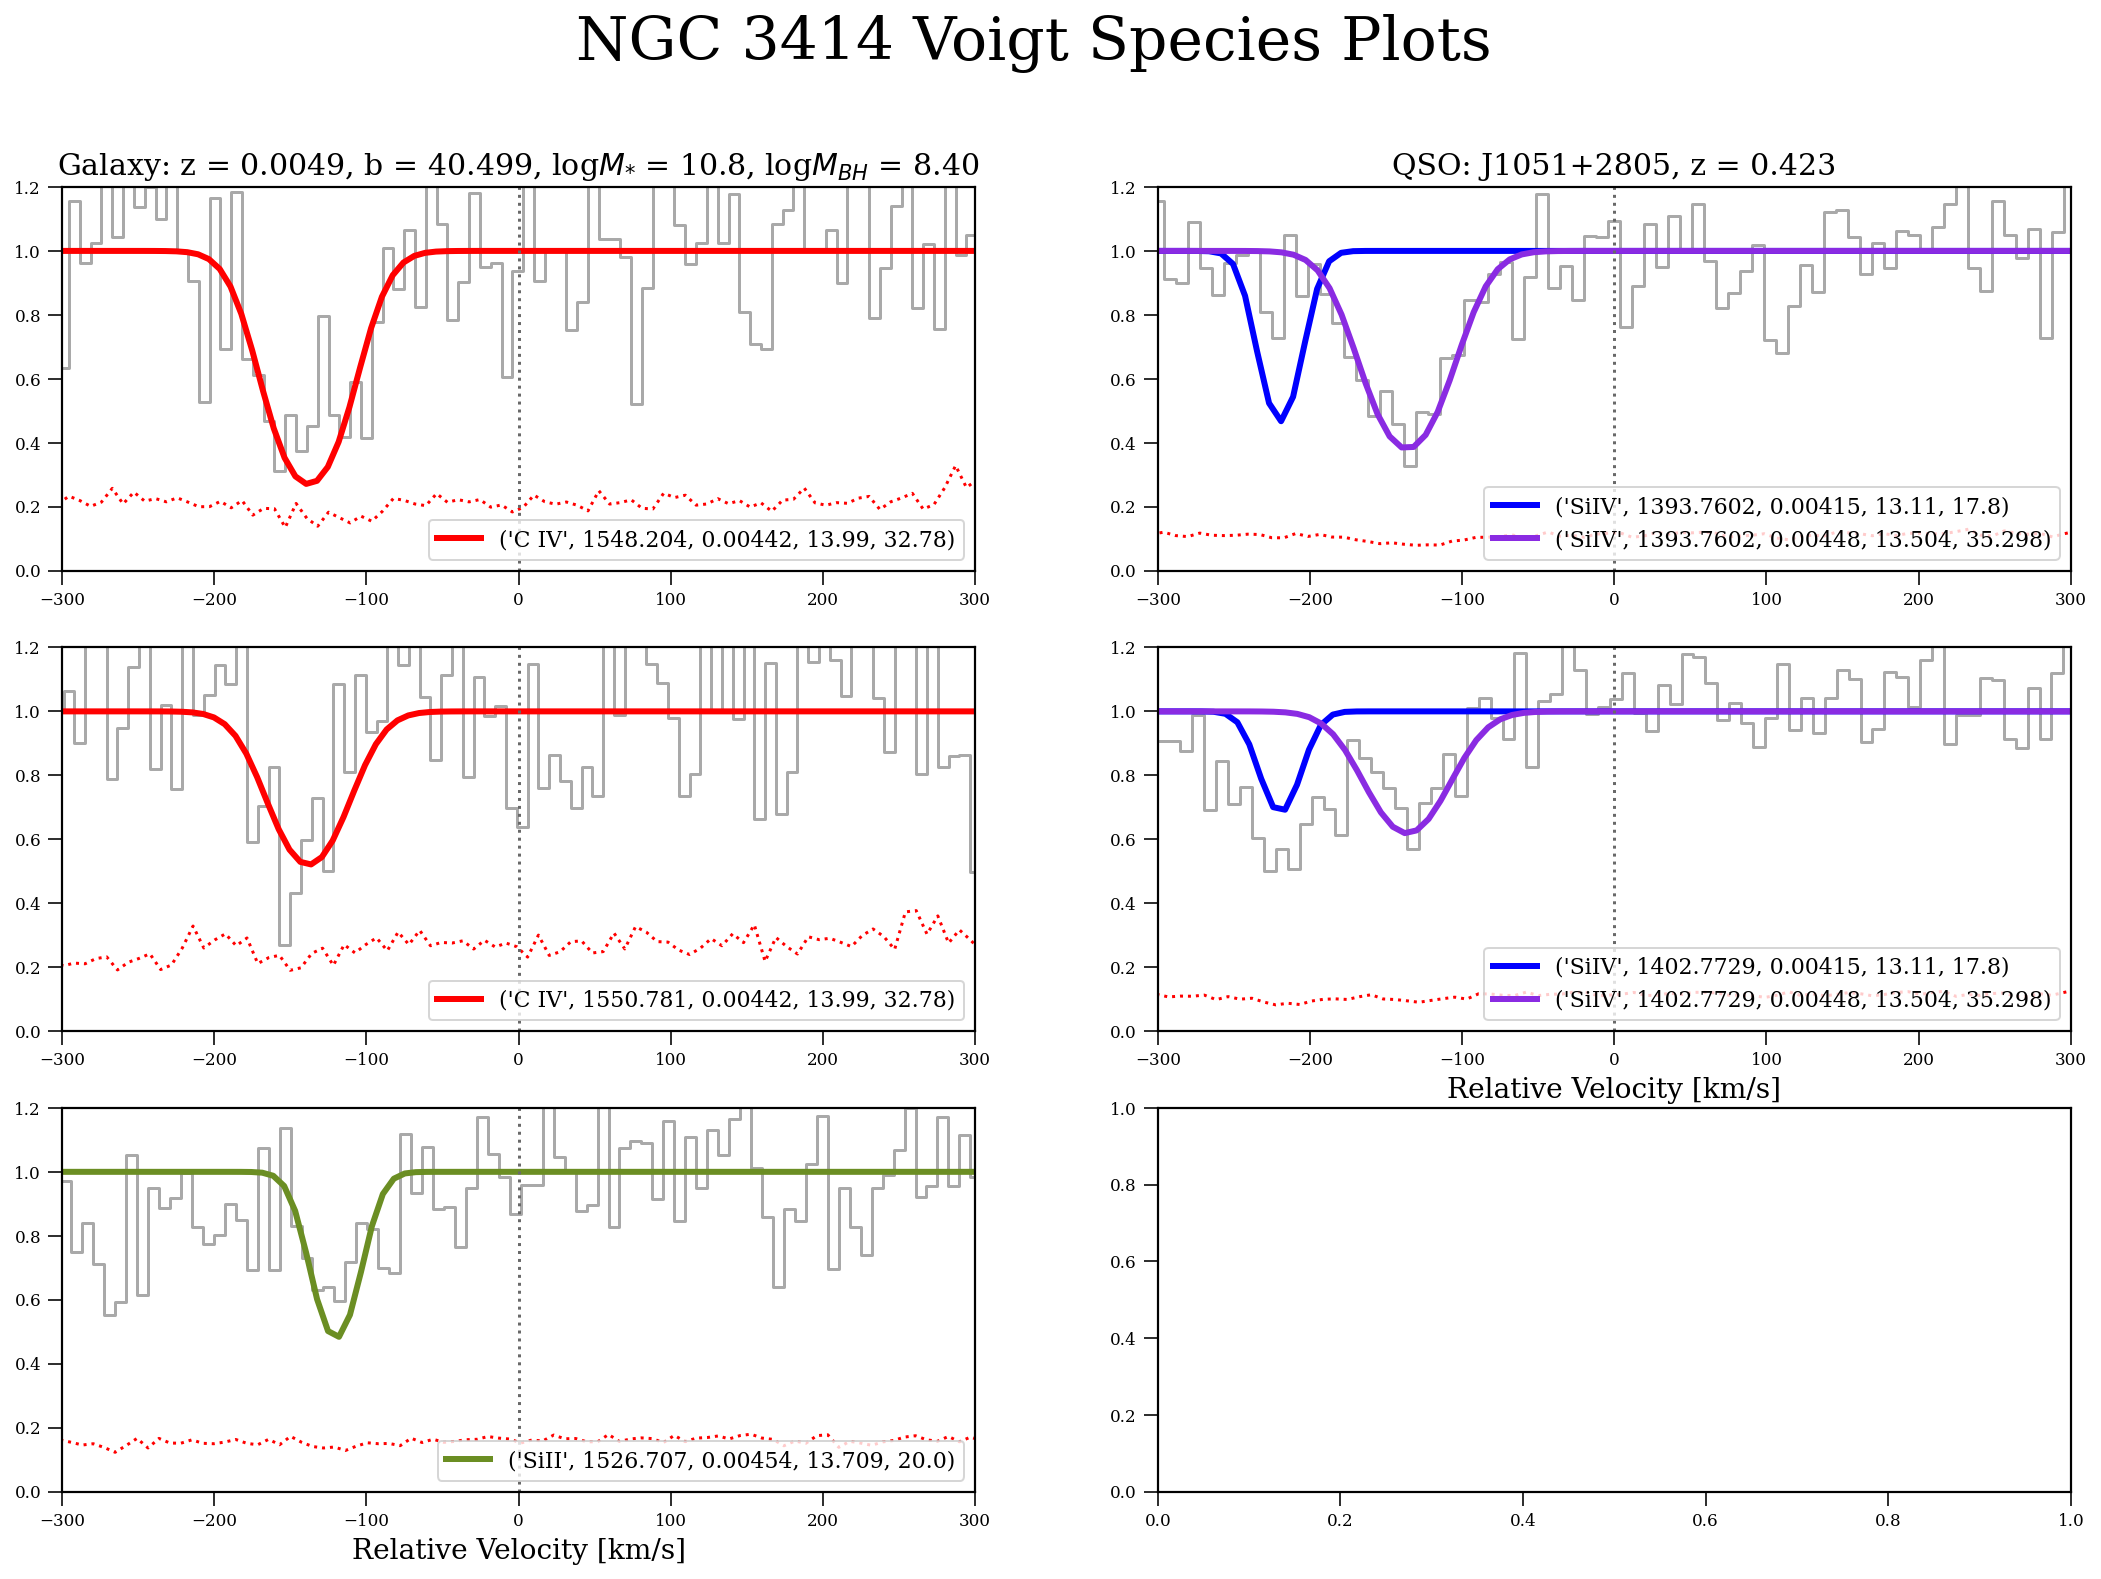

In [24]:
J1051_vsp()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


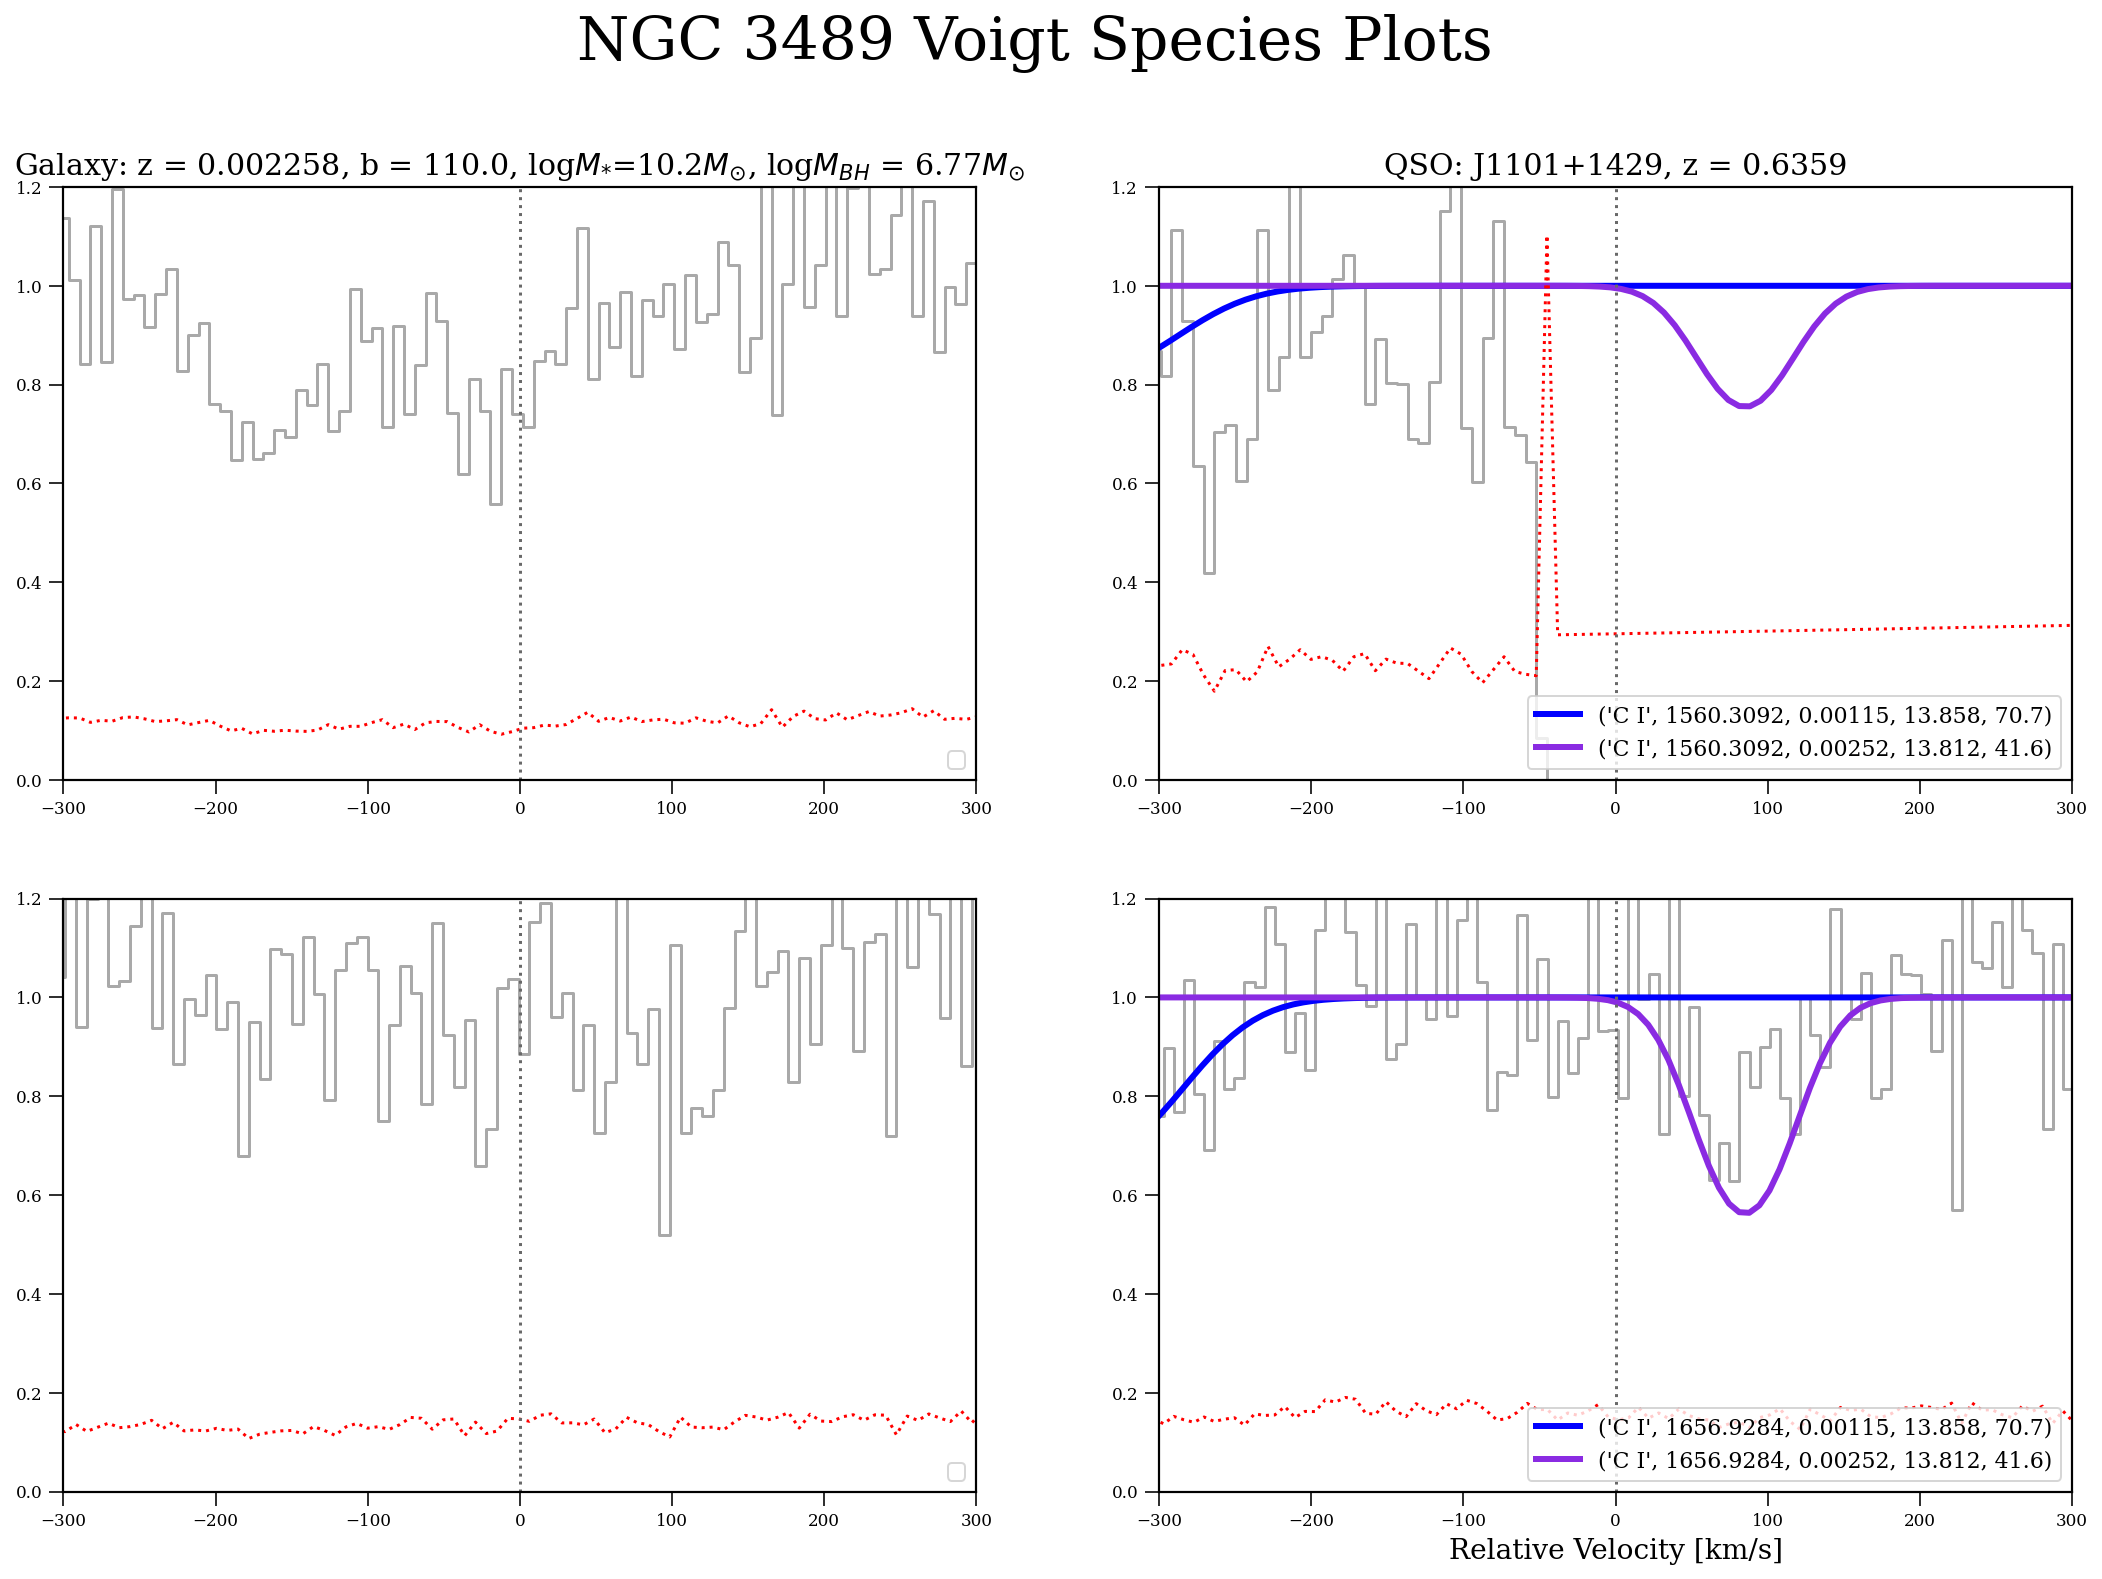

In [54]:
J1101_vsp() #Note I know it looks like there is some absorption but that is coming from residual MW

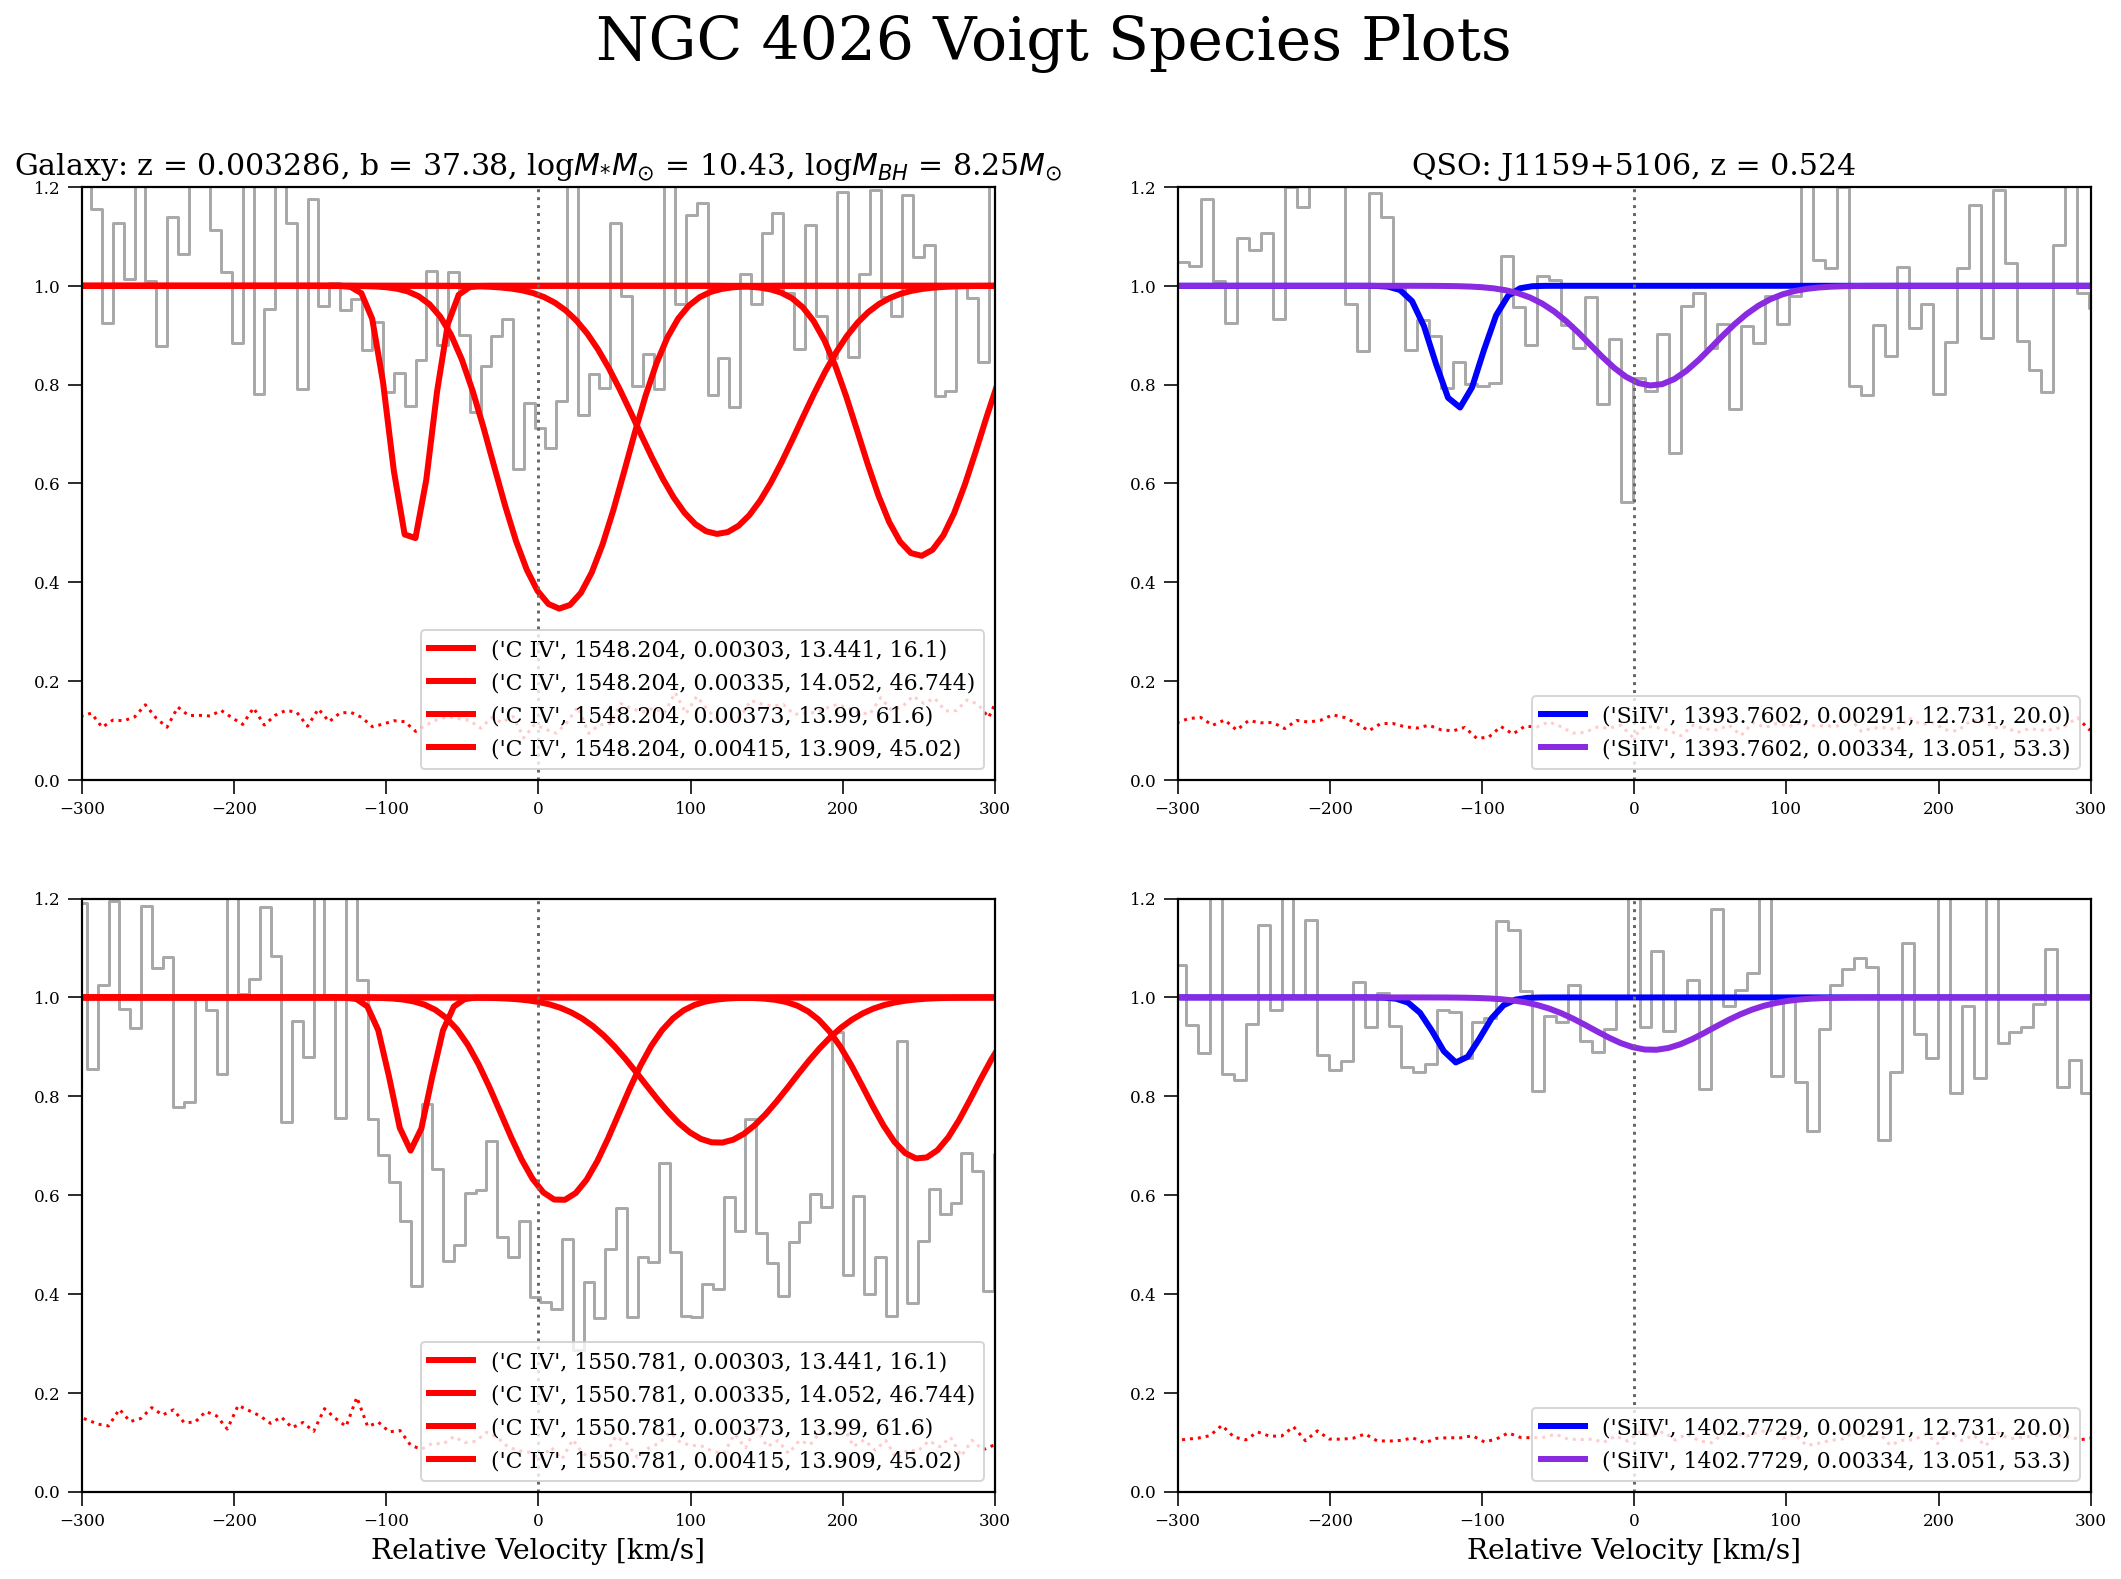

In [69]:
J1159_vsp() #This came out shitty and need to go back and check this out 

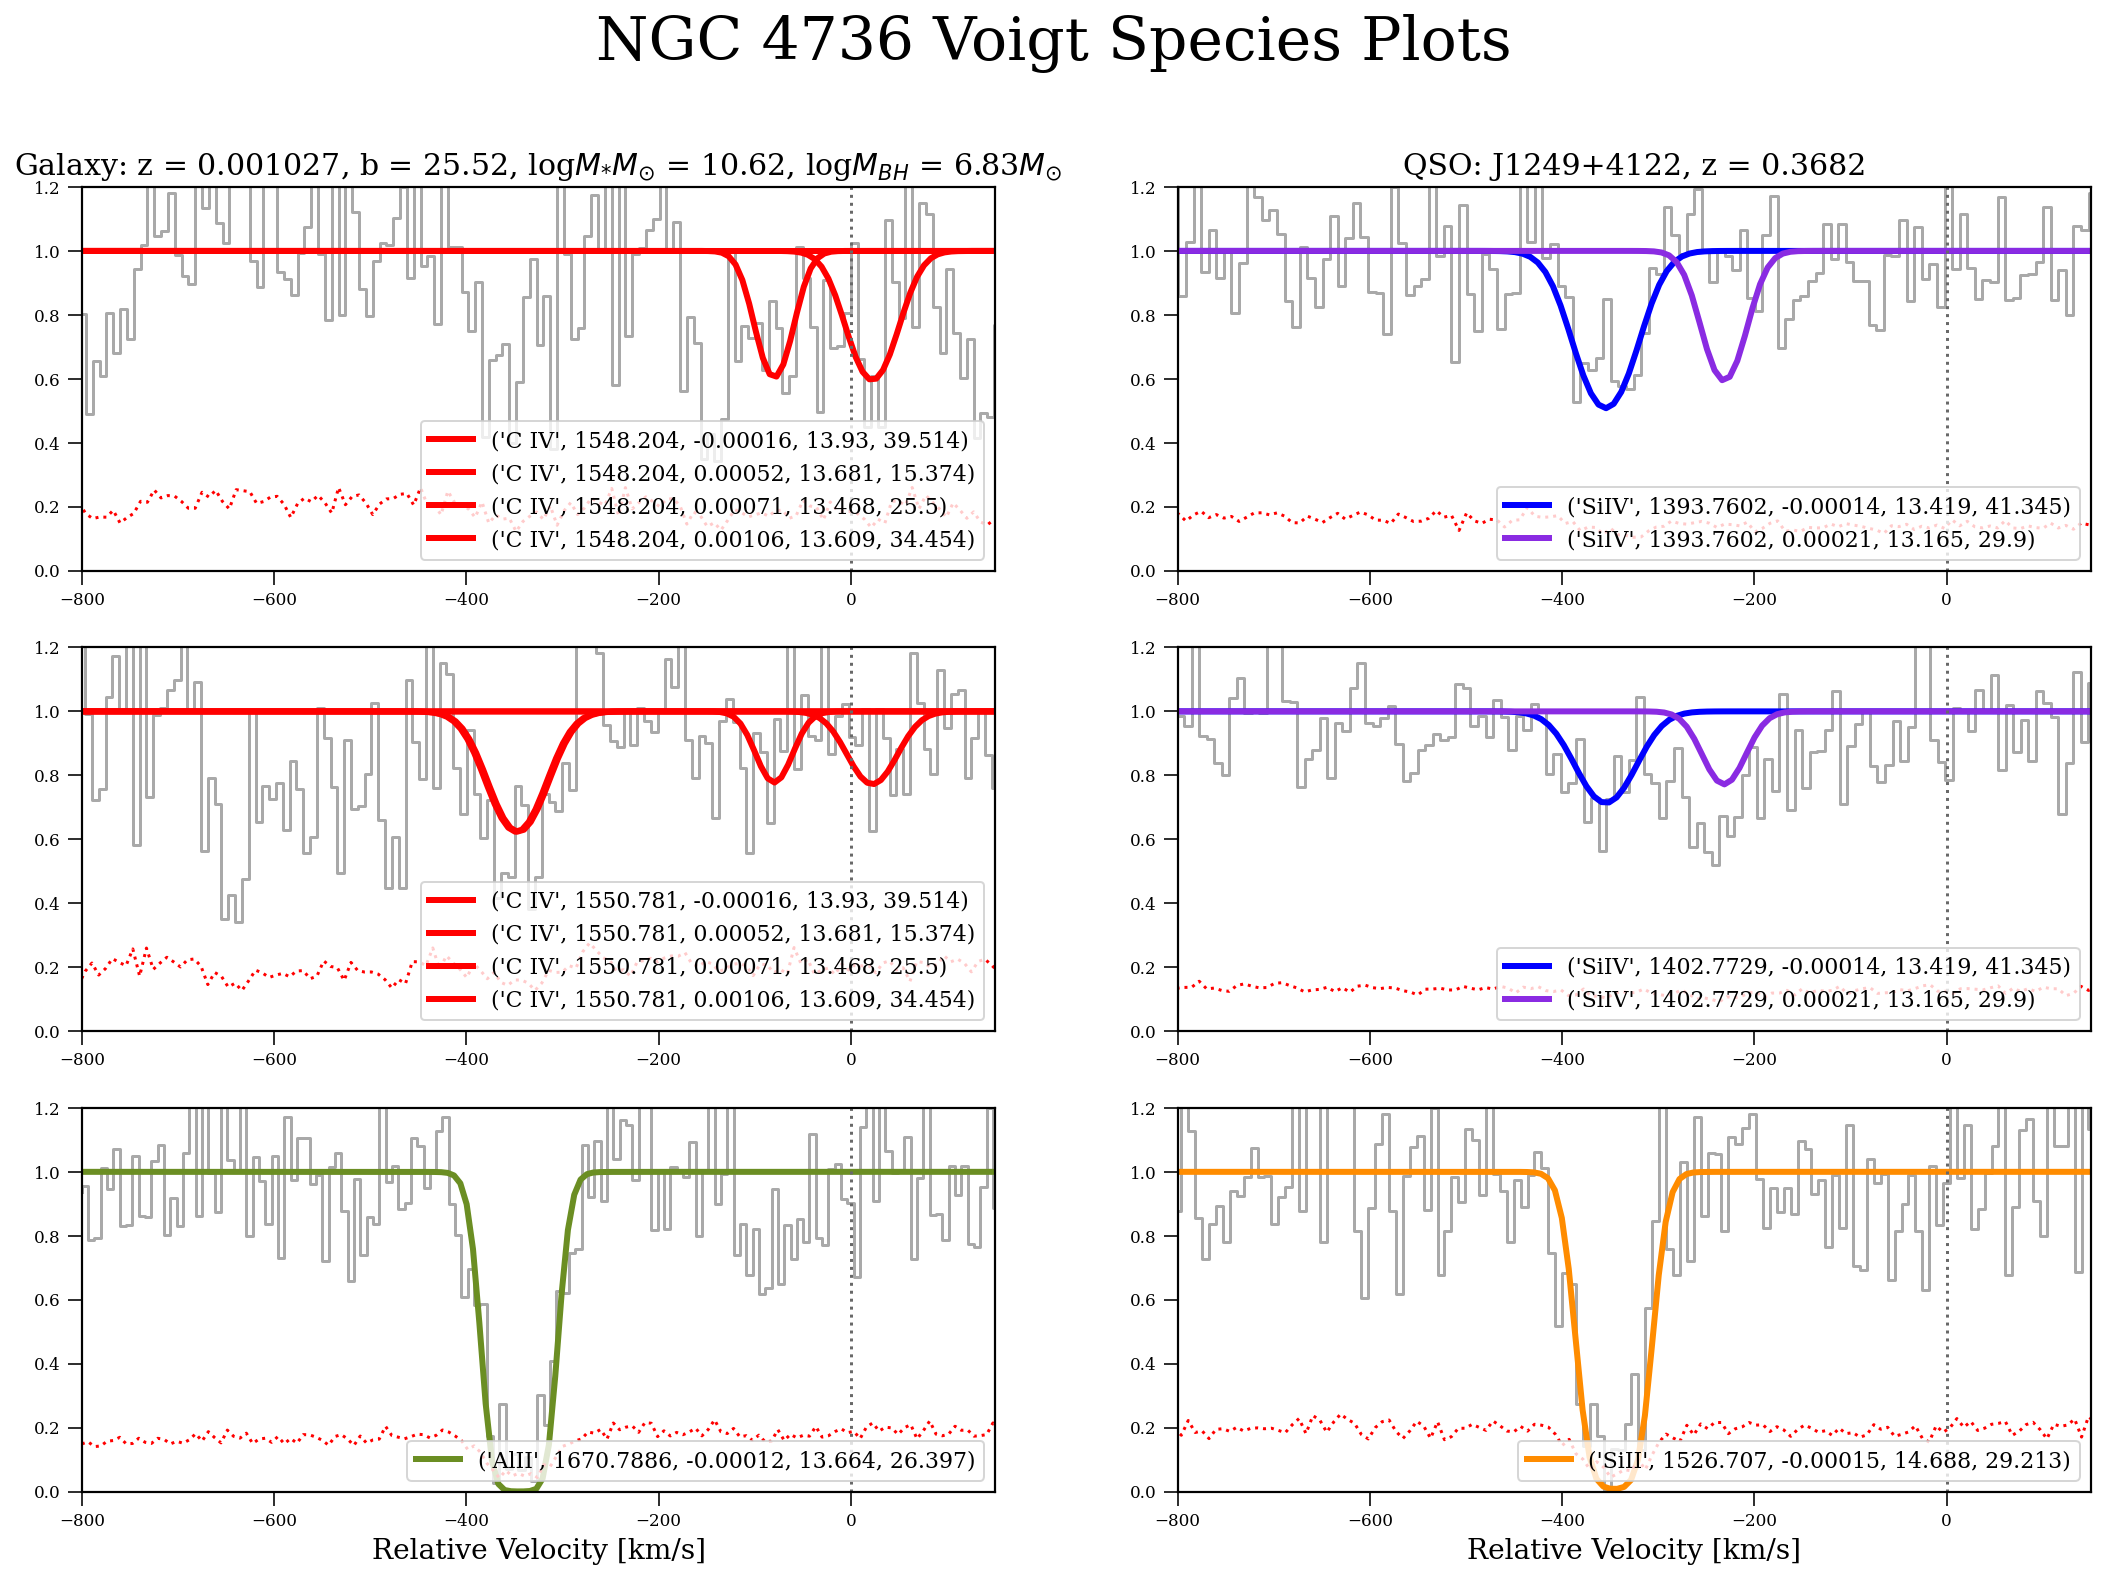

In [83]:
J1249_vsp()